# Decision Tree Counterfactuals on toy causal inference data

In this Notebook, we'll walk you through usage of `DecisionTreeCounterfactual` class for causal inference. We use a simple example of toy causal inference data.

In [1]:
# changing working directory
import sys
sys.path.append("../")
%matplotlib inline

In [2]:
def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

## 0. Data: `make_confounded_data` from `fklearn`

Nubank's `fklearn` module provides a nice causal inference problem generator, so we're going to use the same data generating process and example from its [documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html).

In [3]:
# rodando a função para gerar dados confounded
from fklearn.data.datasets import make_confounded_data
df_rnd, df_obs, df_cf = make_confounded_data(50000)
print(df_to_markdown(df_obs.head(5)))

sex | age | severity | medication | recovery
---- | ---- | ---- | ---- | ----
0 | 16 | 0.047 | 0 | 17
1 | 24 | 0.099 | 0 | 29
1 | 25 | 0.35 | 1 | 105
1 | 52 | 0.54 | 1 | 242
0 | 49 | 0.63 | 1 | 141



We have five features: `sex`, `age`, `severity`, `medication` and `recovery`. We want to estimate the impact of `medication` on `recovery`. So, our *target* variable is `recovery`, our *treatment* variable is `medication` and the rest are our *explanatory* variables.

A good counterfactual model will tell us how would be the recovery time for each individual for both potential decisions of taking or not taking medication. The model should be robust to confounders, variables that affect the probability of someone taking the medication. For instance, people with higher `severity` may be more likely to take the medicine. If not properly taken into account, this confounder may lead us to conclude that the medication may make recovery worse: people that took the medication may have recovered more slowly (but their condition was also more severe). In the [fklearn's documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html), the data generating process is shown in detail, highlighting the confounders in the data. The effect we're looking to is $exp(-1) = 0.368$.

The `make_confounded_data` function outputs three data frames: `df_rnd`, where treatment assingment is random, `df_obs`, where treatment assingment is confounded and `df_cf`, which is the counterfactual dataframe, containing the counterfactual outcome for all the individuals.

Let us try to solve this problem using `DecisionTreeCounterfactual`!

## 1. How `DecisionTreeCounterfactual` works

In causal inference, we aim to answer what would happen if we made a different decision in the past. This is quite hard because we cannot make two decisions simultaneously, or go back in time and check what would happen if we did things differently. However, what we can do is observe what happened to people **who are similar to ourselves** and made different choices. We do this all the time using family members, work colleagues, and friends as references.

But what it means to be similar, and most importantly, can similarity be learned? The answer is YES! For instance, when we run a decision tree, more than solving a classification or a regression problem, we're dividing our data into clusters of similar elements given what features most explain our target. Thus, a decision tree works like a researcher deciding which variables to control to get the best effect estimate!

`DecisionTreeCounterfactual` leverages this *supervised clustering* approach and checks how changes on the *treatment variable* reflect on changes on the *target* given clusters determined by the *explanatory variables* that most impact the target. If we do not have any unobserved variable, we can be confident that the treatment variable really *caused* changes on the target, since everything else will be controlled.

Let us solve `fklearn`'s causal inference problem so we can walk though the method.

## 2. Easy mode: solving `df_rnd`

We call solving `df_rnd` "easy mode" because there's no confounding, making it easy to estimate counterfactuals without paying attention to it. Nevertheless, it provides a good sanity check for `DecisionTreeCounterfactual`.

We first organize data in `X`, `W` and `y` format, needed to fit `DecisionTreeCounterfactual`.

In [4]:
# organizing data into X, W and y
X = df_rnd[['sex','age','severity']]
W = df_rnd['medication']
y = df_rnd['recovery']

In [5]:
# importing cfml-tools
from cfml_tools import DecisionTreeCounterfactual
dtcf = DecisionTreeCounterfactual(save_explanatory=True)

C:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


I advise that you read the docstring to know about the parameters and make the tutorial easier to follow!

Before fitting and getting counterfactuals, a good sanity check is doing 5-fold CV, to test the generalization power of the underlying tree model:

In [6]:
# validating model using 5-fold CV
cv_scores = dtcf.get_cross_val_scores(X, y)
print(cv_scores)

[0.54723148 0.57086291 0.56644823 0.56601209 0.543017  ]


Here, we have R2 scores in the range of ~0.55, which seem reasonable (no overfitting). However, there's actually no baseline here: you just need to be confident that the model can capture and generalize relationships between explanatory variables and the target variable. Nevertheless, here are some tips: If your CV metric is too high (R2 very close to 1.00, for instance), it may mean that the treatment variable has no effect on the outcomes, or its effect is "masked" by correlated proxies in the explanatory variables. If your CV metric is too low (e.g. R2 close to 0), it does not mean that the model isn't useful: the outcome may be explained only by the treatment variable. 

We proceed to fit the model using `X`, `W` and `y`.

In [7]:
# fitting data to our model
dtcf.fit(X, W, y)

Calling `.fit()` builds a decision tree, solving the regression problem from `X` to `y`. But we actually use the decision tree as a *supervised clustering* algorithm. Each leaf of the tree determines a cluster of similar elements given the explanatory variables that most impact the target. Thus, we can calculate counterfactuals at the cluster level, by comparing the outcome of its elements for different `W`. `.fit()` is done when we have a table with counterfactuals by the tree's leaves:

In [8]:
# showing counterfactual training table
print(df_to_markdown(dtcf.leaf_counterfactual_df.reset_index().head(6)))

leaf | W | y | count
---- | ---- | ---- | ----
7 | 0 | 11 | 73
7 | 1 | 30 | 62
9 | 0 | 12 | 51
9 | 1 | 31 | 54
10 | 0 | 13 | 69
10 | 1 | 34 | 102



We then predict the counterfactuals for all our individuals. By calling `.predict()`, we get the dataframe in the `counterfactuals` variable, which stores predictions for both `W = 0` and `W = 1`. The counterfactuals are obtained running the samples in the tree, checking which cluster they've been assigned to, and querying the `leaf_counterfactual_df` built at `.fit()` time for the outcome given different values of `W`.

In [9]:
# let us predict counterfactuals for these guys
counterfactuals = dtcf.predict(X)
counterfactuals.head()

y_hat            
W            0           1
id                        
0    12.641509   34.566038
1    27.724138   73.955056
2    36.464286  100.166667
3   109.932203  296.950820
4    55.356322  149.490909

Then, we can compute treatment effects by using counterfactual information:

In [10]:
# treatment effects
treatment_effects = counterfactuals['y_hat'][0]/counterfactuals['y_hat'][1]

And compare estimated effects vs real effects:

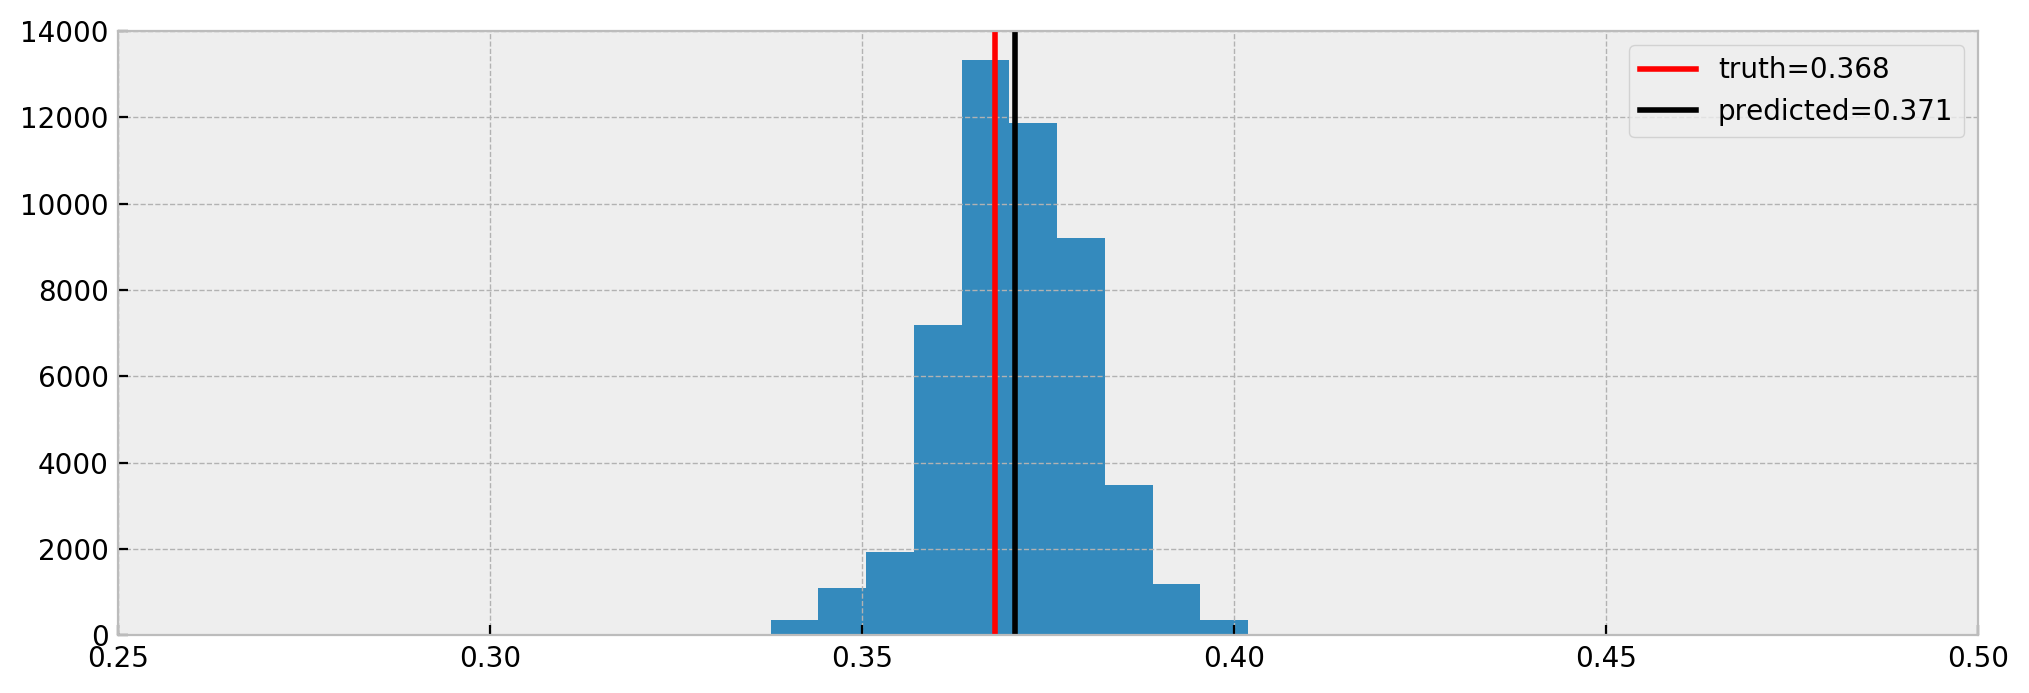

In [11]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=10);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

Cool! As we can see, the model nicely estimated the true effect, but at a lower resolution than `ForestEmbeddingsCounterfactual`.

This seems rather "black-boxy". How can we trust the counterfactual predictions? We can use the `DecisionTreeCounterfactual`'s `.explain()` method! For a given test sample, it returns a table of comparable individuals with their treatment assignments and outcomes!

In [12]:
# our test sample
test_sample = X.iloc[[0]]
print(df_to_markdown(test_sample))

sex | age | severity
---- | ---- | ----
0 | 16 | 0.047



In [13]:
# running explanation
comparables_table = dtcf.explain(test_sample)

# showing comparables table
print(df_to_markdown(comparables_table.groupby('W').head(5).sort_values('W').reset_index()))

index | sex | age | severity | W | y
---- | ---- | ---- | ---- | ---- | ----
1444 | 0 | 15 | 0.049 | 0 | 13
2180 | 0 | 15 | 0.083 | 0 | 10
2379 | 0 | 15 | 0.045 | 0 | 13
3388 | 0 | 16 | 0.078 | 0 | 10
4036 | 0 | 15 | 0.056 | 0 | 18
0 | 0 | 16 | 0.047 | 1 | 31
71 | 0 | 16 | 0.089 | 1 | 35
157 | 0 | 14 | 0.07 | 1 | 30
1096 | 0 | 15 | 0.048 | 1 | 28
1412 | 0 | 14 | 0.093 | 1 | 34



As you can see, the model found a lot of "twins" to the test sample with different treatment assignments and outcomes. By looking at the table it becomes crystal clear that the treatment improves outcomes.

Let us now go for the "hard mode", solving a counterfactual estimation problem with confounding.

## 3. Hard mode: solving `df_obs`

Now, we go for the "hard mode" and try to solve `df_obs`. Now we have confounding, which means that treatment assingment will not be uniform. Nevertheless, we run `ForestEmbeddingsCounterfactual` like before.

Organizing data in `X`, `W` and `y` format again:

In [14]:
# organizing data into X, W and y
X = df_obs[['sex','age','severity']]
W = df_obs['medication']
y = df_obs['recovery']

Fitting the model, same as before:

In [15]:
# importing cfml-tools
from cfml_tools import DecisionTreeCounterfactual
dtcf = DecisionTreeCounterfactual(save_explanatory=True)

In [16]:
# validating model using 5-fold CV
cv_scores = dtcf.get_cross_val_scores(X, y)
print(cv_scores)

[0.90593652 0.9394594  0.94191483 0.93571656 0.93803323]


Here it gets a little bit different. Remember that a high R2 could mean that the treatment variable has little effect on the outcome? As the treatment assignment is correlated with the other variables, they "steal" importance from the treatment and this shows as a higher R2 in the confounded case. 

We proceed to fit the model using `X`, `W` and `y`.

In [17]:
# fitting data to our model
dtcf.fit(X, W, y)

We then predict the counterfactuals for all our individuals. We get the dataframe in the `counterfactuals` variable, which predicts outcomes for both `W = 0` and `W = 1`.

In this case, we can see some NaNs. That's because for some individuals there are not enough treated or untreated neighbors to  estimate the counterfactuals, controlled by the parameter `min_sample_effect`. When this parameter is high, we are conservative, getting more NaNs but less variance in counterfactual estimation.

In [18]:
# let us predict counterfactuals for these guys
counterfactuals = dtcf.predict(X)
counterfactuals.head()

y_hat            
W         0.0         1.0
id                       
0   12.535211         NaN
1   28.181818         NaN
2   35.982456   97.758333
3         NaN  300.767241
4   64.266667  178.568627

Let us now compare true effect with estimated, for all the samples we *could* infer a counterfactual (no NaNs). Will the model get a good estimate in this case? 

C:\Users\Guilherme\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Guilherme\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


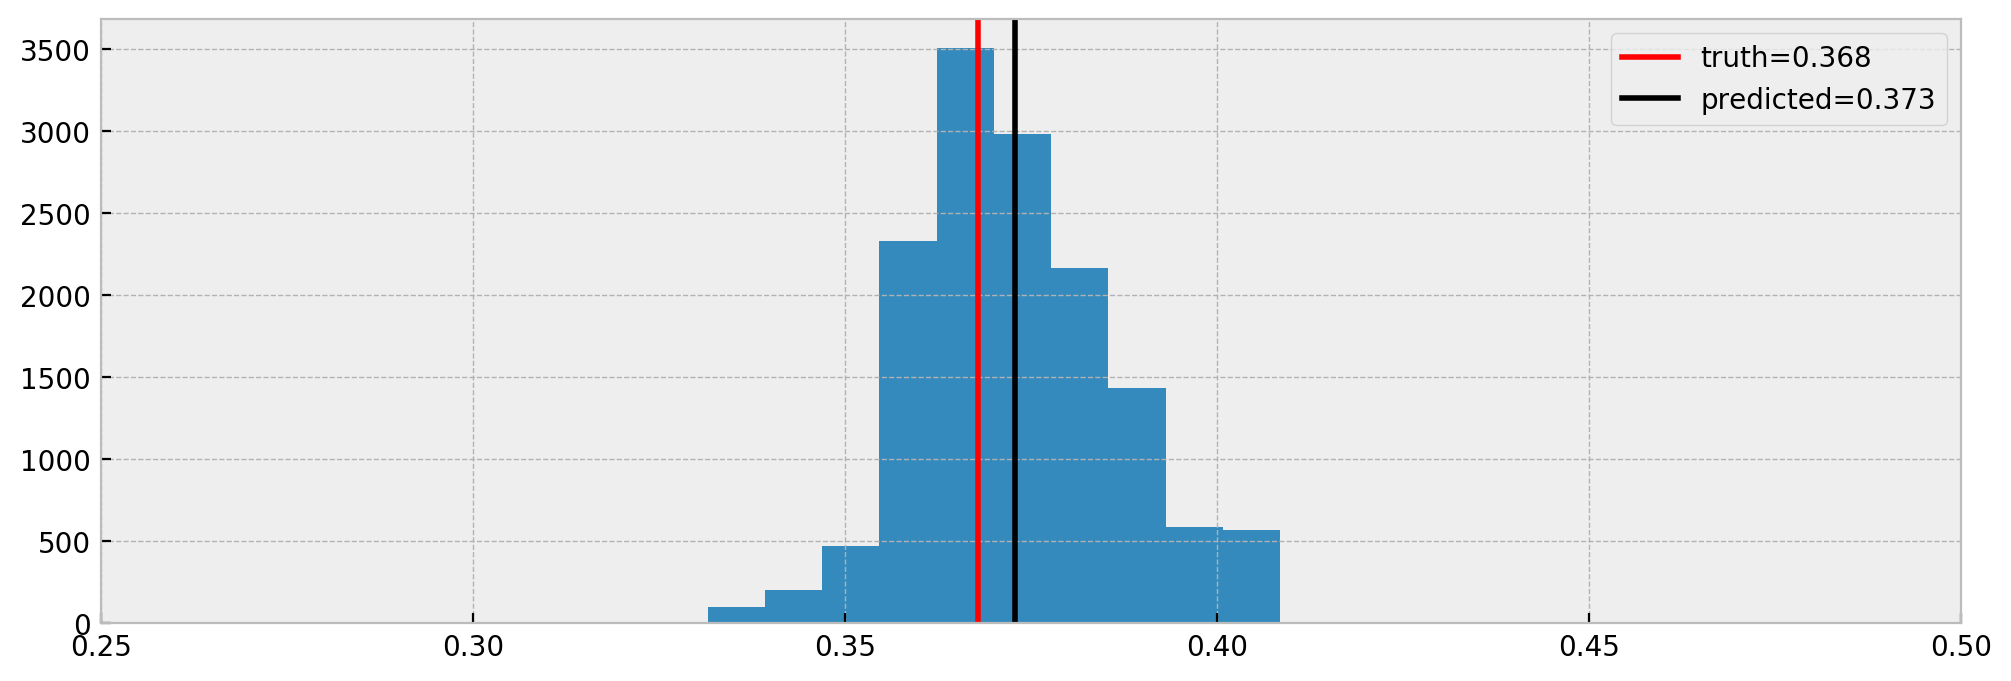

In [19]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][0]/counterfactuals['y_hat'][1]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=10);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

Nice! The model estimated the effect very well again. Note that we have less samples in the histogram, due to NaNs. Nevertheless, it is a cool result and shows that `DecisionTreeCounterfactual` can work with confounded data.

Let us explain the counterfactual of the first prediction, which is NaN for `W = 1`.

In [20]:
# our test sample
test_sample = X.iloc[[0]]
print(df_to_markdown(test_sample))

sex | age | severity
---- | ---- | ----
0 | 16 | 0.047



In [21]:
# running explanation
comparables_table = dtcf.explain(test_sample)

# showing comparables table
print(comparables_table['W'].value_counts())
print(df_to_markdown(comparables_table.groupby('W').head(5).sort_values('W').reset_index()))

0.0    142
Name: W, dtype: int64
index | sex | age | severity | W | y
---- | ---- | ---- | ---- | ---- | ----
0 | 0 | 16 | 0.047 | 0 | 17
990 | 0 | 16 | 0.048 | 0 | 12
2032 | 0 | 17 | 0.029 | 0 | 15
2384 | 0 | 16 | 0.032 | 0 | 8
3127 | 0 | 17 | 0.022 | 0 | 13



In this case, there's no treated comparables for us to draw inferences from. This explains why we cannot predict the outcome for this individual given `W = 1`!

I hope you liked the tutorial and will use `cfml_tools` for your causal inference problems soon!